# Sparkify Project - Small Dataset

This project is based on data from a hypothetical music streaming service named Sparkify. The data comes in two form: The complete set (12 GB) as well as a tiny subset (128 MB). The project's goal is to use the data to predict churning of the service's users.

This notebook is run on a local machine and, therefore, only uses the smaller dataset.

In [1]:
import sys
import time
import datetime
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import col, sum, count, udf, to_timestamp, min, max, avg, when, length
from pyspark.sql.types import TimestampType, FloatType, BooleanType
from pyspark.ml.feature import VectorAssembler, Normalizer
from pyspark.ml.classification import LogisticRegression, NaiveBayes, RandomForestClassifier
from pyspark.ml.evaluation import BinaryClassificationEvaluator, MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sb

%matplotlib inline
sb.set_style("whitegrid")

In [2]:
# create a Spark session
spark = SparkSession \
    .builder \
    .appName("Sparkify") \
    .getOrCreate()

In [3]:
# Load reduced sparkify dataset
mini_event_data = "mini_sparkify_event_data.json"

df = spark.read.json(mini_event_data)
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')

In [4]:
df.count()

286500

# Cleaning the Dataset

### Checking for and excluding dispensable features

**First step**: Get an overview regarding the structure of the data.

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



Have a closer look at the numeric features.

In [6]:
df.describe("itemInSession", "length", "registration").show()

+-------+------------------+-----------------+--------------------+
|summary|     itemInSession|           length|        registration|
+-------+------------------+-----------------+--------------------+
|  count|            286500|           228108|              278154|
|   mean|114.41421291448516|249.1171819778458|1.535358834084427...|
| stddev|129.76726201140994|99.23517921058361| 3.291321616327586E9|
|    min|                 0|          0.78322|       1521380675000|
|    max|              1321|       3024.66567|       1543247354000|
+-------+------------------+-----------------+--------------------+



In [7]:
df.describe("sessionId", "status", "ts").show()

+-------+-----------------+------------------+--------------------+
|summary|        sessionId|            status|                  ts|
+-------+-----------------+------------------+--------------------+
|  count|           286500|            286500|              286500|
|   mean|1041.526554973822|210.05459685863875|1.540956889810483...|
| stddev|726.7762634630741| 31.50507848842214|1.5075439608226302E9|
|    min|                1|               200|       1538352117000|
|    max|             2474|               404|       1543799476000|
+-------+-----------------+------------------+--------------------+



Have a look at the range of values of the categorical features.

In [8]:
for feat in ["auth", "gender", "level", "location", "method", "registration", "status"]:
    print(feat.upper())
    print(df.select(feat).distinct().show(25))

AUTH
+----------+
|      auth|
+----------+
|Logged Out|
| Cancelled|
|     Guest|
| Logged In|
+----------+

None
GENDER
+------+
|gender|
+------+
|     F|
|  null|
|     M|
+------+

None
LEVEL
+-----+
|level|
+-----+
| free|
| paid|
+-----+

None
LOCATION
+--------------------+
|            location|
+--------------------+
|     Gainesville, FL|
|Atlantic City-Ham...|
|Deltona-Daytona B...|
|San Diego-Carlsba...|
|Cleveland-Elyria, OH|
|Kingsport-Bristol...|
|New Haven-Milford...|
|Birmingham-Hoover...|
|  Corpus Christi, TX|
|         Dubuque, IA|
|Las Vegas-Henders...|
|Indianapolis-Carm...|
|Seattle-Tacoma-Be...|
|          Albany, OR|
|   Winston-Salem, NC|
|     Bakersfield, CA|
|Los Angeles-Long ...|
|Minneapolis-St. P...|
|San Francisco-Oak...|
|Phoenix-Mesa-Scot...|
|Allentown-Bethleh...|
|Miami-Fort Lauder...|
|           Selma, AL|
|          Dayton, OH|
|San Jose-Sunnyval...|
+--------------------+
only showing top 25 rows

None
METHOD
+------+
|method|
+------+
|   PUT|

In [9]:
df.groupby("page").count().sort("count", ascending=False).show(100)

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|                Home| 14457|
|           Thumbs Up| 12551|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|               Login|  3241|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|                Help|  1726|
|            Settings|  1514|
|               About|   924|
|             Upgrade|   499|
|       Save Settings|   310|
|               Error|   258|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
|            Register|    18|
| Submit Registration|     5|
+--------------------+------+



Look at the `status` variable to see how it relates to the `page` variable.

In [10]:
df.groupby("page", "status").count().show(100)

+--------------------+------+------+
|                page|status| count|
+--------------------+------+------+
| Submit Registration|   307|     5|
|           Downgrade|   200|  2055|
|       Save Settings|   307|   310|
|                Help|   200|  1726|
|Cancellation Conf...|   200|    52|
|            Settings|   200|  1514|
|          Add Friend|   307|  4277|
|             Upgrade|   200|   499|
|         Roll Advert|   200|  3933|
|      Submit Upgrade|   307|   159|
|               Error|   404|   258|
|                Home|   200| 14457|
|               About|   200|   924|
|               Login|   307|  3241|
|     Add to Playlist|   200|  6526|
|              Logout|   307|  3226|
|         Thumbs Down|   307|  2546|
|              Cancel|   307|    52|
|            Register|   200|    18|
|           Thumbs Up|   307| 12551|
|            NextSong|   200|228108|
|    Submit Downgrade|   307|    63|
+--------------------+------+------+



Look at the `method` variable to see how it relates to the `page` variable.

In [11]:
df.groupby("page", "method").count().show(100)

+--------------------+------+------+
|                page|method| count|
+--------------------+------+------+
|          Add Friend|   PUT|  4277|
|              Logout|   PUT|  3226|
|               About|   GET|   924|
|      Submit Upgrade|   PUT|   159|
|     Add to Playlist|   PUT|  6526|
|              Cancel|   PUT|    52|
|    Submit Downgrade|   PUT|    63|
|            Settings|   GET|  1514|
|               Login|   PUT|  3241|
|       Save Settings|   PUT|   310|
|                Help|   GET|  1726|
|           Downgrade|   GET|  2055|
|            Register|   GET|    18|
|             Upgrade|   GET|   499|
|               Error|   GET|   258|
|Cancellation Conf...|   GET|    52|
|         Thumbs Down|   PUT|  2546|
|                Home|   GET| 14457|
| Submit Registration|   PUT|     5|
|         Roll Advert|   GET|  3933|
|            NextSong|   PUT|228108|
|           Thumbs Up|   PUT| 12551|
+--------------------+------+------+



**Findings / Next step**: The features `method`, `status`, and `userAgent` seem to be primarily technical in nature. Therefore, the next step will be to exclude these features from the dataset.

In [12]:
df = df.drop("method", "status", "userAgent")
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', ts=1538352117000, userId='30')

### Checking for and handling missing data

In [13]:
# count NaNs per column
for c in df.columns:
    count = df.filter((col(c).isNull() == True) | (col(c) == "")).count()
    print(f"{c}: {count}")

artist: 58392
auth: 0
firstName: 8346
gender: 8346
itemInSession: 0
lastName: 8346
length: 58392
level: 0
location: 8346
page: 0
registration: 8346
sessionId: 0
song: 58392
ts: 0
userId: 8346


**Finding**: Lots of missing values which might, however, be due to the nature of the records.

**Next step**: Analyze the missing data per type of page. This should help to understand the structure of the dataset.

In [14]:
def show_missing_data(df, save_fig):
    
    """Shows the occurance of nan values in a pyspark dataframe
    
    Inputs 
    df (pyspark dataframe):   A pyspark dataframe with a number of features and a column 
                              labelled 'page' which specifies the type of the entry.
    save_fig (boolean):       Indicates whether the plot is to be saved to the current 
                              working directory.
    
    Returns
    Nothing but plots a figure which shows the structural occurances
    of nan values.
    """
    
    # create initial dataframe with column "page"
    null_vals = df.select("page").distinct()
    # inspect the dataframe column by column and count the number of nans and ""s in each
    for c in df.columns:
        next = df.filter((df[c].isNull() == True) | (df[c] == "")).groupby("page") \
                                                                  .count() \
                                                                  .withColumnRenamed("count", c)
        null_vals = null_vals.join(next, ["page"], "outer")
    df = df.sort("page")

    # copy data into a Pandas DataFrame to facilitate plotting
    p_null_vals = null_vals.toPandas()

    # remove duplicate pages column
    pages = p_null_vals["page"].iloc[:,0].values
    p_null_vals.drop("page", axis=1, inplace=True)
    p_null_vals["page"] = pages
    

    # convert values into a binary format:
    # if null values exist then TRUE else FALSE
    for c in p_null_vals.columns[:-1]:
        p_null_vals[c] = [False if str(x) in ["None", "nan"] else True for x in p_null_vals[c]]

    
    # make a plot which shows the occurances of null values
    plt.figure(figsize=(9, 9))
    yticklabels = [x.title() for x in p_null_vals.columns[:-1]]
    sb.heatmap(p_null_vals.iloc[:, :-1].transpose(), xticklabels=pages, 
               yticklabels=yticklabels, cmap=["white", "red"], cbar=False, 
               square=True, linewidths=0.05, linecolor="grey");
    plt.xlabel("Type of page/transaction", fontsize=11.5);
    plt.ylabel("Dataset feature", fontsize=11.5);
    title = plt.title("The red squares show where in the dataset NULL VALUES occur", 
                      loc="left", fontsize=12.5);
    title.set_position([0, 1.03]);
    
    if save_fig:
        plt.savefig("features_after_cleaning.jpeg", format="jpeg", dpi=300, bbox_inches="tight")

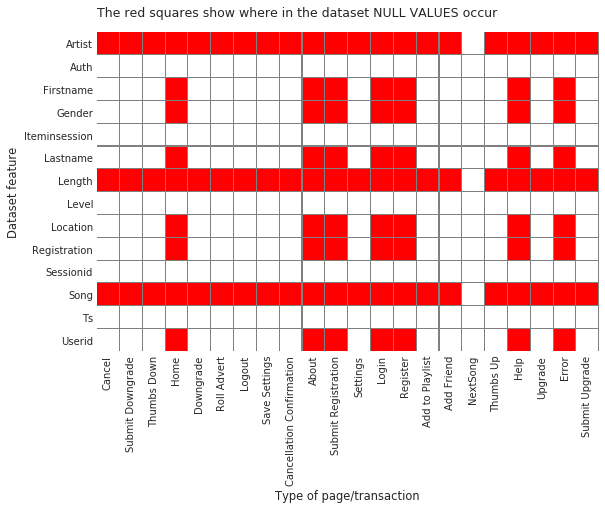

In [15]:
show_missing_data(df, False)

**Findings**: 
- `Artist`, `Song`, and `Length` are only specified for `NextSong` records.
- There are some types of pages for which the personal attributes of the user (`UserId`, `Firstname`, `Lastname`, `Gender`, `Location`, `Registration`) are not recorded.

**Next step**: The objective of this analysis is to make predictions on user behavior. Therefore, I will remove interactions for which no user information is available.

In [16]:
df = df.filter(df.userId != "")

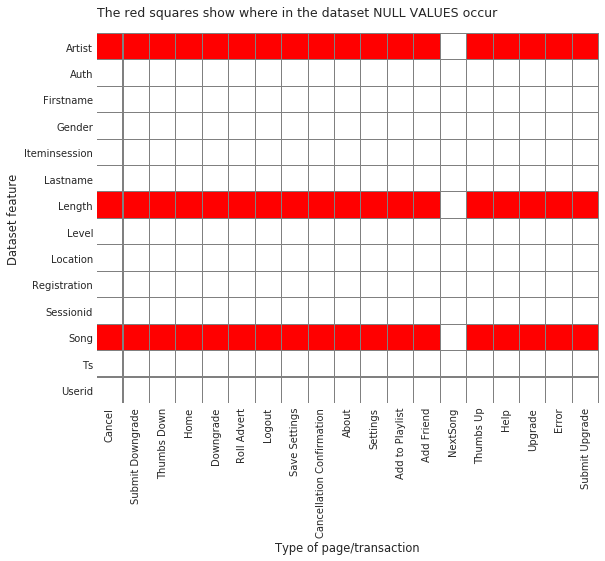

In [17]:
show_missing_data(df, True)

### Ensuring data tidiness

**First step**: Check for duplicates in those columns where duplicates are not to be expected.

In [18]:
# Combination of columns for which no duplicates should exist
columns = ["userId", "sessionId", "itemInSession"]

if df.count() > df.dropDuplicates(columns).count():
    print("Data has duplicates.")
else:
    print("No duplicates.")

No duplicates.


**Next step**: Check for adequacy of data types.

In [19]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- ts: long (nullable = true)
 |-- userId: string (nullable = true)



**Finding / Next step**: Timestamp (`ts`) should be a datetime (or similar) variable.

In [20]:
df = df.withColumn("timestamp", to_timestamp(df.ts / 1e3))
df = df.drop("ts")

In [21]:
df.count()

278154

# Exploratory Data Analysis

### Definion of Churn

The `Cancellation Confirmation` event is used to identify user who churn. 

### Data Exploration

In [22]:
columns = ["userId", "auth", "gender", "sessionId", "itemInSession", "level", "timestamp"]
df.filter(df.page == "Cancellation Confirmation").select(columns).show(52)

+------+---------+------+---------+-------------+-----+-------------------+
|userId|     auth|gender|sessionId|itemInSession|level|          timestamp|
+------+---------+------+---------+-------------+-----+-------------------+
|    18|Cancelled|     M|      514|          104| paid|2018-10-07 20:26:30|
|    32|Cancelled|     M|      540|           56| paid|2018-10-08 21:10:46|
|   125|Cancelled|     M|      174|           10| free|2018-10-12 04:35:18|
|   105|Cancelled|     M|      508|          332| paid|2018-10-12 20:17:21|
|    17|Cancelled|     F|      797|          273| paid|2018-10-13 21:19:44|
|   143|Cancelled|     F|      843|           29| free|2018-10-15 07:34:14|
|   101|Cancelled|     M|      842|          145| paid|2018-10-16 22:30:37|
|   129|Cancelled|     M|      802|           34| paid|2018-10-17 00:29:21|
|   121|Cancelled|     M|      881|          287| paid|2018-10-17 07:02:29|
|    51|Cancelled|     M|      934|          176| paid|2018-10-17 07:39:32|
|    87|Canc

**Question**: Of all users in the dataset how many did cancel the service?

In [23]:
canc_rate = df.filter(df.page == "Cancellation Confirmation").groupby("userId").count().count() / \
            df.groupby("userId").count().count() * 100
print(f"{canc_rate:.1f}%")

23.1%


**Question**: How does the proportion of female users who cancelled the service relate to their overall proportion in the dataset?

In [24]:
overall_fem_prop = df.filter(df.gender == "F").groupby("userId").count().count() \
                   / df.groupby("userId").count().count() * 100
print(f"Overall rate of females in the dataset: {overall_fem_prop:.1f}%")

canc_fem_prop = df.filter((df.gender == "F") & (df.page == "Cancellation Confirmation")) \
                .groupby("userId").count().count() \
                / df.filter(df.page == "Cancellation Confirmation") \
                .groupby("userId").count().count() * 100
print(f"Rate of females among users who cancelled: {canc_fem_prop:.1f}%")

Overall rate of females in the dataset: 46.2%
Rate of females among users who cancelled: 38.5%


**Question**: How does the proportion of paying users who cancelled the service relate to the overall proportion of paying users in the dataset?

In [25]:
overall_pay_prop = df.filter(df.level == "paid").groupby("userId").count().count() \
                   / df.groupby("userId").count().count() * 100
print(f"Overall proportion of paying users: {overall_pay_prop:.1f}%")

canc_pay_prop = df.filter((df.level == "paid") & (df.page == "Cancellation Confirmation")) \
                .groupby("userId").count().count() \
                / df.filter(df.page == "Cancellation Confirmation") \
                .groupby("userId").count().count() * 100
print(f"Proportion of paying users among the users who cancelled: {canc_pay_prop:.1f}%")

Overall proportion of paying users: 73.3%
Proportion of paying users among the users who cancelled: 59.6%


**Question**: What were the last actions of users who cancelled the service? Look at some examples.

In [26]:
df.filter(df.page == "Cancellation Confirmation").select("userId", "page").show(10)

+------+--------------------+
|userId|                page|
+------+--------------------+
|    18|Cancellation Conf...|
|    32|Cancellation Conf...|
|   125|Cancellation Conf...|
|   105|Cancellation Conf...|
|    17|Cancellation Conf...|
|   143|Cancellation Conf...|
|   101|Cancellation Conf...|
|   129|Cancellation Conf...|
|   121|Cancellation Conf...|
|    51|Cancellation Conf...|
+------+--------------------+
only showing top 10 rows



In [27]:
columns = ["userId", "page", "auth", "gender", "sessionId", "itemInSession", "level", "timestamp", "length"]
df.filter(df.userId == 17).select(columns).sort("timestamp", ascending=False).show(10)

+------+--------------------+---------+------+---------+-------------+-----+-------------------+---------+
|userId|                page|     auth|gender|sessionId|itemInSession|level|          timestamp|   length|
+------+--------------------+---------+------+---------+-------------+-----+-------------------+---------+
|    17|Cancellation Conf...|Cancelled|     F|      797|          273| paid|2018-10-13 21:19:44|     null|
|    17|              Cancel|Logged In|     F|      797|          272| paid|2018-10-13 21:17:31|     null|
|    17|            Settings|Logged In|     F|      797|          271| paid|2018-10-13 21:17:30|     null|
|    17|            NextSong|Logged In|     F|      797|          270| paid|2018-10-13 21:09:26|236.45995|
|    17|            NextSong|Logged In|     F|      797|          269| paid|2018-10-13 21:03:19|367.12444|
|    17|            NextSong|Logged In|     F|      797|          268| paid|2018-10-13 20:59:04|255.92118|
|    17|            NextSong|Logged I

In [28]:
df.filter(df.userId == 124).select(columns).sort("timestamp", ascending=False).show(10)

+------+--------+---------+------+---------+-------------+-----+-------------------+---------+
|userId|    page|     auth|gender|sessionId|itemInSession|level|          timestamp|   length|
+------+--------+---------+------+---------+-------------+-----+-------------------+---------+
|   124|    Home|Logged In|     F|     2426|            0| paid|2018-11-30 15:12:46|     null|
|   124|    Home|Logged In|     F|     2372|          130| paid|2018-11-29 19:48:06|     null|
|   124|    Home|Logged In|     F|     2372|          129| paid|2018-11-29 19:47:22|     null|
|   124|  Logout|Logged In|     F|     2372|          126| paid|2018-11-29 19:45:18|     null|
|   124|NextSong|Logged In|     F|     2372|          125| paid|2018-11-29 19:45:17| 67.44771|
|   124|NextSong|Logged In|     F|     2372|          124| paid|2018-11-29 19:40:03|314.72281|
|   124|NextSong|Logged In|     F|     2372|          123| paid|2018-11-29 19:36:49|194.76853|
|   124|NextSong|Logged In|     F|     2372|      

In [29]:
df.filter(df.userId == 51).select(columns).sort("timestamp", ascending=False).show(10)

+------+--------------------+---------+------+---------+-------------+-----+-------------------+---------+
|userId|                page|     auth|gender|sessionId|itemInSession|level|          timestamp|   length|
+------+--------------------+---------+------+---------+-------------+-----+-------------------+---------+
|    51|Cancellation Conf...|Cancelled|     M|      934|          176| paid|2018-10-17 07:39:32|     null|
|    51|              Cancel|Logged In|     M|      934|          175| paid|2018-10-17 07:37:10|     null|
|    51|            Settings|Logged In|     M|      934|          174| paid|2018-10-17 07:37:09|     null|
|    51|            NextSong|Logged In|     M|      934|          173| paid|2018-10-17 07:35:26|212.34893|
|    51|            NextSong|Logged In|     M|      934|          172| paid|2018-10-17 07:31:48|218.93179|
|    51|            NextSong|Logged In|     M|      934|          171| paid|2018-10-17 07:27:49|239.85587|
|    51|            NextSong|Logged I

**Question**: Which time span is covered by the dataset?

In [30]:
df.agg(min(df.timestamp)).show()
df.agg(max(df.timestamp)).show()
df.agg(max(df.timestamp)).collect()[0][0] - df.agg(min(df.timestamp)).collect()[0][0]

+-------------------+
|     min(timestamp)|
+-------------------+
|2018-10-01 00:01:57|
+-------------------+

+-------------------+
|     max(timestamp)|
+-------------------+
|2018-12-03 01:11:16|
+-------------------+



datetime.timedelta(63, 4159)

In [31]:
4159/3600

1.1552777777777778

The dataset covers a time span of roughly 63 days and 1 hour.

# Feature Engineering

In [32]:
df.head()

Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', userId='30', timestamp=datetime.datetime(2018, 10, 1, 0, 1, 57))

**New feature 1**: Number of total interactions (`count_interactions`) of a user.

In [33]:
df_users = df.select("userId", "gender").sort("userId").groupby("userId", "gender").count()
df_users = df_users.withColumnRenamed("count", "count_interactions")
df_users.show(5)

+------+------+------------------+
|userId|gender|count_interactions|
+------+------+------------------+
|    10|     M|               795|
|   100|     M|              3214|
|100001|     F|               187|
|100002|     F|               218|
|100003|     F|                78|
+------+------+------------------+
only showing top 5 rows



**New feature 2**: User is male (`male`).

In [34]:
is_male = udf(lambda x: True if x == "M" else False, BooleanType())
df_users = df_users.withColumn("male", is_male(df_users.gender)).drop("gender")
df_users.show(5)

+------+------------------+-----+
|userId|count_interactions| male|
+------+------------------+-----+
|    10|               795| true|
|   100|              3214| true|
|100001|               187|false|
|100002|               218|false|
|100003|                78|false|
+------+------------------+-----+
only showing top 5 rows



**New features 3 and 4**: Number of likes (`count_thumbs_up`) and dislikes (`count_thumbs_down`) provided by a user according to the available records.

In [35]:
def count_interactions(interaction_name, new_col_name, df_interactions=df, df_users=df_users):
    """Counts interaction in the interaction dataframe and appends a column 
    with the count to the user dataframe.
    
    Inputs: 
    interaction_name (str): the 'page' category in the interactions dataframe
    new_col_name (str): the label of the column to be added to the user dataframe
    df_interactions (pyspark dataframe): a dataframe containing the interactions 
                                         labelled in the 'page' column for users
                                         labelled in the 'userId' column
    df_users (pyspark dataframe): a dataframe containing the users (column 'userId') 
                                  for whom the interactions are counted
    
    Returns: 
    df_users (pyspark dataframe): the user dataframe with a new column containing the 
                                  interaction counts
    """
    
    interaction_count = df.filter(df.page == interaction_name).groupby("userId").count()
    df_users = df_users.join(interaction_count, "userId", "left")
    df_users = df_users.fillna(0, ["count"])
    df_users = df_users.withColumnRenamed("count", new_col_name)
    
    return df_users

In [36]:
start_time = time.time()

# counting thumbs up per user
df_users = count_interactions("Thumbs Up", "count_thumbs_up", df, df_users)
# counting thumbs down per user
df_users = count_interactions("Thumbs Down", "count_thumbs_down", df, df_users)

df_users.show(5)

print(f"Operations took {time.time() - start_time:.1f} seconds.")

+------+------------------+-----+---------------+-----------------+
|userId|count_interactions| male|count_thumbs_up|count_thumbs_down|
+------+------------------+-----+---------------+-----------------+
|100010|               381|false|             17|                5|
|200002|               474| true|             21|                6|
|   125|                11| true|              0|                0|
|   124|              4825|false|            171|               41|
|    51|              2464| true|            100|               21|
+------+------------------+-----+---------------+-----------------+
only showing top 5 rows

Operations took 19.7 seconds.


**New features 5 and 6**: Total number of additions to a playlist (`count_playlist`) and total number of friend additions  (`count_friends`) by the user.

In [37]:
start_time = time.time()

# counting thumbs up per user
df_users = count_interactions("Add to Playlist", "count_playlist", df, df_users)
# counting thumbs down per user
df_users = count_interactions("Add Friend", "count_friends", df, df_users)

df_users.show(5)

print(f"Operations took {time.time() - start_time:.1f} seconds.")

+------+------------------+-----+---------------+-----------------+--------------+-------------+
|userId|count_interactions| male|count_thumbs_up|count_thumbs_down|count_playlist|count_friends|
+------+------------------+-----+---------------+-----------------+--------------+-------------+
|100010|               381|false|             17|                5|             7|            4|
|200002|               474| true|             21|                6|             8|            4|
|   125|                11| true|              0|                0|             0|            0|
|   124|              4825|false|            171|               41|           118|           74|
|    51|              2464| true|            100|               21|            52|           28|
+------+------------------+-----+---------------+-----------------+--------------+-------------+
only showing top 5 rows

Operations took 21.3 seconds.


**New features 7 and 8**: Total number of advertisements (`count_ads`) and errors (`count_errors`) the user has seen.

In [38]:
start_time = time.time()

# counting thumbs up per user
df_users = count_interactions("Roll Advert", "count_ads", df, df_users)
# counting thumbs down per user
df_users = count_interactions("Error", "count_errors", df, df_users)

df_users.select("userId", "count_ads", "count_errors").show(5)

print(f"Operations took {time.time() - start_time:.1f} seconds.")

+------+---------+------------+
|userId|count_ads|count_errors|
+------+---------+------------+
|100010|       52|           0|
|200002|        7|           0|
|   125|        1|           0|
|   124|        4|           6|
|    51|        0|           1|
+------+---------+------------+
only showing top 5 rows

Operations took 14.5 seconds.


**New feature 9**: Time since the last interaction (`duration_inactivity_hrs`) in hours -excluding cancellation- by the user.

In [39]:
start_time = time.time()

# Determine the time of the last user interaction -excluding cancellation- 
# and append it to the user dataframe
df_temp = df.filter(~df.page.isin(["Cancel", "Cancellation Confirmation"])) \
            .select("userId", 
                    "timestamp", 
                    max("timestamp").over(Window.partitionBy("userId")).alias("time_last_action"))
df_temp = df_temp.groupby("userId").agg(max(df_temp.time_last_action).alias("time_last_action"))
df_users = df_users.join(df_temp, "userId", "left")

# Determine the time of the last entry in the df and calculate 
# the time elapsed since the last action of the user as determined above
last_timestamp = df.agg(max(df.timestamp)).collect()[0][0]
duration = udf(lambda x: round((last_timestamp - x).total_seconds() / 3600, 2), FloatType())
df_users = df_users.withColumn("duration_inactivity_hrs", duration(df_users.time_last_action))
df_users = df_users.drop("time_last_action")
df_users.select("userId", "duration_inactivity_hrs").show(5)

print(f"Operations took {time.time() - start_time:.1f} seconds.")

+------+-----------------------+
|userId|duration_inactivity_hrs|
+------+-----------------------+
|100010|                 270.98|
|200002|                 409.76|
|   125|                 1244.6|
|   124|                  57.98|
|    51|                1121.57|
+------+-----------------------+
only showing top 5 rows

Operations took 21.3 seconds.


**New feature 10**: Number of songs (`count_songs_7d`) listened to by a user in the last 7 days.

In [40]:
start_time = time.time()

# Determine the point in time 7 days before the last dataset entry
seven_days_ago = last_timestamp - datetime.timedelta(days=7)

df_temp = df.filter((df.timestamp >= seven_days_ago) & (df.page == "NextSong")).groupby("userId").count()
df_users = df_users.join(df_temp, "userId", "left")
df_users = df_users.fillna(0, ["count"])
df_users = df_users.withColumnRenamed("count", "count_songs_7d")
df_users.select("userId", "count_interactions", "count_songs_7d").show(5)

print(f"Operations took {time.time() - start_time:.1f} seconds.")

+------+------------------+--------------+
|userId|count_interactions|count_songs_7d|
+------+------------------+--------------+
|100010|               381|             0|
|200002|               474|             0|
|   125|                11|             0|
|   124|              4825|           216|
|    51|              2464|             0|
+------+------------------+--------------+
only showing top 5 rows

Operations took 21.2 seconds.


**New feature 11**: Average time (in minutes) a user listened to a song (`avg_time_song_min`).

In [41]:
start_time = time.time()

# Calculate for every user the average duration (in minutes) per song he/she played
# and append this information to the user dataframe
df_temp = df.filter(df.page == "NextSong").groupby("userId").agg((avg("length")/60).alias("avg_time_song_min"))
df_temp = df_temp.groupby("userId").agg(max(df_temp.avg_time_song_min).alias("avg_time_song_min"))
df_users = df_users.join(df_temp, "userId", "left")
df_users.select("userId", "avg_time_song_min").show(5)

print(f"Operations took {time.time() - start_time:.1f} seconds.")

+------+------------------+
|userId| avg_time_song_min|
+------+------------------+
|100010|4.0570240818181835|
|200002| 4.048616534883718|
|   125| 4.352318958333334|
|   124|4.1362756099942795|
|    51| 4.131342513816519|
+------+------------------+
only showing top 5 rows

Operations took 22.6 seconds.


**New features 12 and 13**: User has upgraded (`upgrade`) and or downgraded (`downgrade`) the service.

In [42]:
start_time = time.time()

df_users = count_interactions("Submit Upgrade", "upgrade", df, df_users)
df_users = count_interactions("Submit Downgrade", "downgrade", df, df_users)
df_users = df_users.withColumn("upgrade", when(df_users.upgrade != 0, True).otherwise(False))
df_users = df_users.withColumn("downgrade", when(df_users.upgrade != 0, True).otherwise(False))
df_users.select("userId", "upgrade", "downgrade").show(5)

print(f"Operations took {time.time() - start_time:.1f} seconds.")

+------+-------+---------+
|userId|upgrade|downgrade|
+------+-------+---------+
|100010|  false|    false|
|200002|   true|     true|
|   125|  false|    false|
|   124|  false|    false|
|    51|  false|    false|
+------+-------+---------+
only showing top 5 rows

Operations took 25.4 seconds.


**New feature 14**: User currently paying for the service (`paying`).

In [43]:
start_time = time.time()

w = Window.partitionBy("userId")
df_temp = df.withColumn("maxTimestamp", max("timestamp").over(w)) \
            .where(col("timestamp") == col("maxTimestamp")) \
            .select("userId", "level") \
            .dropDuplicates()
df_users = df_users.join(df_temp, "userId", "left")
df_users = df_users.withColumn("paying", when(df_users.level == "paid", True).otherwise(False)).drop("level")
df_users.select("userId", "paying").show(5)

print(f"Operations took {time.time() - start_time:.1f} seconds.")

+------+------+
|userId|paying|
+------+------+
|100010| false|
|200002|  true|
|   125| false|
|   124|  true|
|    51|  true|
+------+------+
only showing top 5 rows

Operations took 26.9 seconds.


**New feature 15**: User has cancelled the service (`cancelled`).

In [44]:
start_time = time.time()

df_users = count_interactions("Cancellation Confirmation", "cancelled", df, df_users)
df_users = df_users.withColumn("cancelled", when(df_users.cancelled != 0, True).otherwise(False))
df_users.select("userId", "cancelled").show(5)

print(f"Operations took {time.time() - start_time:.1f} seconds.")

+------+---------+
|userId|cancelled|
+------+---------+
|100010|    false|
|200002|    false|
|   125|     true|
|   124|    false|
|    51|     true|
+------+---------+
only showing top 5 rows

Operations took 29.0 seconds.


In [45]:
df_users.printSchema()

root
 |-- userId: string (nullable = true)
 |-- count_interactions: long (nullable = false)
 |-- male: boolean (nullable = true)
 |-- count_thumbs_up: long (nullable = true)
 |-- count_thumbs_down: long (nullable = true)
 |-- count_playlist: long (nullable = true)
 |-- count_friends: long (nullable = true)
 |-- count_ads: long (nullable = true)
 |-- count_errors: long (nullable = true)
 |-- duration_inactivity_hrs: float (nullable = true)
 |-- count_songs_7d: long (nullable = true)
 |-- avg_time_song_min: double (nullable = true)
 |-- upgrade: boolean (nullable = false)
 |-- downgrade: boolean (nullable = false)
 |-- paying: boolean (nullable = false)
 |-- cancelled: boolean (nullable = false)



In [47]:
df_users.write.mode('overwrite').save("users_df.json")

# Modeling
The full dataset is to be split into a train, test, and validation set. Three alternative machine learning methods will be implemented before selecting the most useful model. The model optimization and the model selection will be based on the F1 score.

In [48]:
df_users = spark.read.load("users_df.json")
df_users.show(5)

+------+------------------+-----+---------------+-----------------+--------------+-------------+---------+------------+-----------------------+--------------+------------------+-------+---------+------+---------+
|userId|count_interactions| male|count_thumbs_up|count_thumbs_down|count_playlist|count_friends|count_ads|count_errors|duration_inactivity_hrs|count_songs_7d| avg_time_song_min|upgrade|downgrade|paying|cancelled|
+------+------------------+-----+---------------+-----------------+--------------+-------------+---------+------------+-----------------------+--------------+------------------+-------+---------+------+---------+
|100004|              1245|false|             35|               11|            23|           19|       86|           2|                  94.56|           325| 4.095548288924273|   true|     true|  true|    false|
|   104|              2132|false|             84|               17|            43|           23|       23|           1|                  125.2|     

In [49]:
# convert independent features into vector
ignore = ["userId", "cancelled"]
inputCols = [c for c in df_users.columns if c not in ignore]
vec_assembler = VectorAssembler(inputCols=inputCols, outputCol="user_features")
df_users = vec_assembler.transform(df_users)

# normalize features vector
scaler = Normalizer(inputCol="user_features", outputCol="user_features_norm")
df_users = scaler.transform(df_users)

df_users.select("userId", "user_features_norm").show(5)

+------+--------------------+
|userId|  user_features_norm|
+------+--------------------+
|100004|[0.96218712022672...|
|   104|[0.99703909886638...|
|    60|[0.99479921632502...|
|    68|(14,[0,2,5,6,8,10...|
|    90|(14,[0,1,6,8,10],...|
+------+--------------------+
only showing top 5 rows



In [50]:
data = df_users.select(col("user_features_norm").alias("features"),
                       col("cancelled").alias("label"))
# convert label into numeric
data = data.withColumn("label", col("label").cast("integer"))
data.count()

225

In [51]:
# split the data into a training, testing and validation set
train, temp = data.randomSplit([0.6, 0.4], seed=42)
test, validate = temp.randomSplit([0.5, 0.5], seed=42)
train.count(), test.count(), validate.count()

(134, 48, 43)

In [52]:
def evaluation(preds):
    """Prints aggregated prediction results and calculates evaluation metrics. 
    
    Input 
    preds: PySpark ml prediction dataframe
    
    Returns Nothing
    """
    
    preds.groupBy('label','prediction').count().show()

    accuracy = MulticlassClassificationEvaluator(metricName='accuracy').evaluate(preds)
    recall_label0 = preds.filter((preds.label == 0) & (preds.prediction == 0)).count() / \
                    preds.filter(preds.label == 0).count()
    recall_label1 = preds.filter((preds.label == 1) & (preds.prediction == 1)).count() / \
                    preds.filter(preds.label == 1).count()
    f1 = MulticlassClassificationEvaluator(metricName='f1').evaluate(preds)

    print(f"Accuracy: {accuracy:.2f}")
    print(f"Recall: [{recall_label0:.2f}, " \
                     f"{recall_label1:.2f}]")
    print(f"F1 score: {f1:.2f}")

### Model 1: Logistic regressor

In [53]:
start_time = time.time()

lr = LogisticRegression(maxIter=10)
param_grid = ParamGridBuilder() \
             .addGrid(lr.regParam, [0, 0.05, 0.1]) \
             .addGrid(lr.elasticNetParam, [0.1, 0.2, 0.5, 1]) \
             .addGrid(lr.fitIntercept, [True, False]) \
             .build()
lr_cross_val = CrossValidator(estimator=lr,
                              estimatorParamMaps=param_grid,
                              evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                              numFolds=3,
                              seed=42)
lr_cv_model = lr_cross_val.fit(train)
lr_best_model = lr_cv_model.bestModel

lr_best_model.summary.predictions.show(5)

print(f"Operations took {time.time() - start_time:.1f} seconds.")

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(14,[0,1,3,4,6,8,...|  1.0|[-1.0525201198485...|[0.25874146235375...|       1.0|
|(14,[0,1,6,8,9,10...|  0.0|[16.8659853482594...|[0.99999995266355...|       0.0|
|(14,[0,1,6,8,10],...|  0.0|[7.77406467944662...|[0.99957967615809...|       0.0|
|(14,[0,2,3,4,5,6,...|  0.0|[1.12908541560613...|[0.75567007629418...|       0.0|
|(14,[0,2,3,4,5,6,...|  0.0|[2.55175855950894...|[0.92769156743476...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows

Operations took 89.7 seconds.


In [54]:
print("Logistic Regression - TRAINING Evaluation")
lr_best_model.summary.predictions.groupBy('label','prediction').count().show()
print(f"Accuracy: {lr_best_model.summary.accuracy:.2f}")
print(f"Recall: [{lr_best_model.summary.recallByLabel[0]:.2f}, " \
                 f"{lr_best_model.summary.recallByLabel[1]:.2f}]")
f1 = MulticlassClassificationEvaluator(metricName='f1').evaluate(lr_best_model.summary.predictions)
print(f"F1 score: {f1:.2f}")

Logistic Regression - TRAINING Evaluation
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|  1.0|       1.0|   31|
|  0.0|       1.0|    7|
|  1.0|       0.0|    7|
|  0.0|       0.0|   89|
+-----+----------+-----+

Accuracy: 0.90
Recall: [0.93, 0.82]
F1 score: 0.90


81 % of users who cancelled the service are identified as such.

In [55]:
lr_best_model.extractParamMap()

{Param(parent='LogisticRegression_0b19b4a0db77', name='aggregationDepth', doc='suggested depth for treeAggregate (>= 2)'): 2,
 Param(parent='LogisticRegression_0b19b4a0db77', name='elasticNetParam', doc='the ElasticNet mixing parameter, in range [0, 1]. For alpha = 0, the penalty is an L2 penalty. For alpha = 1, it is an L1 penalty'): 0.1,
 Param(parent='LogisticRegression_0b19b4a0db77', name='family', doc='The name of family which is a description of the label distribution to be used in the model. Supported options: auto, binomial, multinomial.'): 'auto',
 Param(parent='LogisticRegression_0b19b4a0db77', name='featuresCol', doc='features column name'): 'features',
 Param(parent='LogisticRegression_0b19b4a0db77', name='fitIntercept', doc='whether to fit an intercept term'): True,
 Param(parent='LogisticRegression_0b19b4a0db77', name='labelCol', doc='label column name'): 'label',
 Param(parent='LogisticRegression_0b19b4a0db77', name='maxIter', doc='maximum number of iterations (>= 0)'): 

In [56]:
lr_test_preds = lr_best_model.transform(test)
lr_test_preds.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(14,[0,2,3,4,5,6,...|    0|[-1.2271265506002...|[0.22668474224588...|       1.0|
|(14,[0,2,5,6,8,10...|    0|[9.47776679042581...|[0.99992347119271...|       0.0|
|(14,[0,2,5,6,8,10...|    0|[8.26047512886067...|[0.99974153069958...|       0.0|
|[0.52153946193275...|    1|[-0.6914717456120...|[0.33370575611854...|       1.0|
|[0.62421092678694...|    1|[-1.4201005625885...|[0.19464581903436...|       1.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [57]:
print("Logistic Regression - TEST Evalutation")
evaluation(lr_test_preds)

Logistic Regression - TEST Evalutation
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    2|
|    0|       0.0|   39|
|    1|       1.0|    5|
|    0|       1.0|    2|
+-----+----------+-----+

Accuracy: 0.92
Recall: [0.95, 0.71]
F1 score: 0.92


86 % of users who cancelled the service are identified as such.

### Model 2: Naive Bayes classifier

In [58]:
start_time = time.time()

nb = NaiveBayes()

param_grid = ParamGridBuilder() \
             .addGrid(nb.smoothing, [0, 0.1, 0.3, 0.5]) \
             .addGrid(nb.thresholds, [[0.75, 0.25], [0.7, 0.3], [0.65, 0.35]]) \
             .build()
nb_cross_val = CrossValidator(estimator=nb,
                              estimatorParamMaps=param_grid,
                              evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                              numFolds=5,
                              seed=42)
nb_cv_model = nb_cross_val.fit(train)
nb_best_model = nb_cv_model.bestModel

nb_train_preds = nb_best_model.transform(train)
nb_train_preds.show(10)

print(f"Operations took {time.time() - start_time:.1f} seconds.")

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(14,[0,1,3,4,6,8,...|    1|[-1.7929874260709...|[0.58040168534853...|       1.0|
|(14,[0,1,6,8,9,10...|    0|[-2.0230173114033...|[0.58730185455228...|       1.0|
|(14,[0,1,6,8,10],...|    0|[-1.9564933523227...|[0.59427048794050...|       1.0|
|(14,[0,2,3,4,5,6,...|    0|[-2.1846293160900...|[0.64086424153697...|       1.0|
|(14,[0,2,3,4,5,6,...|    0|[-2.1685149216613...|[0.68502790567176...|       0.0|
|(14,[0,2,3,4,5,8,...|    0|[-1.9088645780680...|[0.60012617732343...|       1.0|
|(14,[0,2,3,4,6,8,...|    1|[-2.2120181264073...|[0.65245401649007...|       0.0|
|(14,[0,2,4,5,6,8,...|    0|[-2.7228938397498...|[0.70993159063136...|       0.0|
|(14,[0,2,4,5,6,9,...|    0|[-1.2498746140820...|[0.78616574300724...|       0.0|
|(14,[0,2,4,5,8,

In [59]:
nb_best_model.extractParamMap()

{Param(parent='NaiveBayes_03b16ec4def2', name='featuresCol', doc='features column name'): 'features',
 Param(parent='NaiveBayes_03b16ec4def2', name='labelCol', doc='label column name'): 'label',
 Param(parent='NaiveBayes_03b16ec4def2', name='modelType', doc='The model type which is a string (case-sensitive). Supported options: multinomial (default) and bernoulli.'): 'multinomial',
 Param(parent='NaiveBayes_03b16ec4def2', name='predictionCol', doc='prediction column name'): 'prediction',
 Param(parent='NaiveBayes_03b16ec4def2', name='probabilityCol', doc='Column name for predicted class conditional probabilities. Note: Not all models output well-calibrated probability estimates! These probabilities should be treated as confidences, not precise probabilities'): 'probability',
 Param(parent='NaiveBayes_03b16ec4def2', name='rawPredictionCol', doc='raw prediction (a.k.a. confidence) column name'): 'rawPrediction',
 Param(parent='NaiveBayes_03b16ec4def2', name='smoothing', doc='The smoothing

In [60]:
print("Naive Bayes - TRAINING Evalutation")
evaluation(nb_train_preds)

Naive Bayes - TRAINING Evalutation
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|   23|
|    0|       0.0|   81|
|    1|       1.0|   15|
|    0|       1.0|   15|
+-----+----------+-----+

Accuracy: 0.72
Recall: [0.84, 0.39]
F1 score: 0.71


59 % of users who cancelled the service are identified as such.

In [61]:
nb_test_preds = nb_best_model.transform(test)
nb_test_preds.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(14,[0,2,3,4,5,6,...|    0|[-2.3461615022255...|[0.70373506877228...|       0.0|
|(14,[0,2,5,6,8,10...|    0|[-2.0913446400085...|[0.59650859073510...|       1.0|
|(14,[0,2,5,6,8,10...|    0|[-2.1535376431645...|[0.60037061565416...|       1.0|
|[0.52153946193275...|    1|[-2.2147082189297...|[0.64471360592210...|       1.0|
|[0.62421092678694...|    1|[-2.1418083260783...|[0.66390748559650...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [62]:
print("Naive Bayes - TEST Evalutation")
evaluation(nb_test_preds)

Naive Bayes - TEST Evalutation
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    4|
|    0|       0.0|   34|
|    1|       1.0|    3|
|    0|       1.0|    7|
+-----+----------+-----+

Accuracy: 0.77
Recall: [0.83, 0.43]
F1 score: 0.79


71 % of users who cancelled the service are identified as such.

### Model 3: Random forest classifier

In [63]:
start_time = time.time()

rfc = RandomForestClassifier()

param_grid = ParamGridBuilder() \
             .addGrid(rfc.maxDepth, [5, 10, 15]) \
             .addGrid(rfc.numTrees, [10, 20, 30]) \
             .build()
rfc_cross_val = CrossValidator(estimator=rfc,
                               estimatorParamMaps=param_grid,
                               evaluator=MulticlassClassificationEvaluator(metricName="f1"),
                               numFolds=5,
                               seed=42)
rfc_cv_model = rfc_cross_val.fit(train)
rfc_best_model = rfc_cv_model.bestModel

rfc_train_preds = rfc_best_model.transform(train)
rfc_train_preds.show(10)

print(f"Operations took {time.time() - start_time:.1f} seconds.")

+--------------------+-----+-------------+--------------------+----------+
|            features|label|rawPrediction|         probability|prediction|
+--------------------+-----+-------------+--------------------+----------+
|(14,[0,1,3,4,6,8,...|    1|   [4.5,25.5]|         [0.15,0.85]|       1.0|
|(14,[0,1,6,8,9,10...|    0|   [29.0,1.0]|[0.96666666666666...|       0.0|
|(14,[0,1,6,8,10],...|    0|   [30.0,0.0]|           [1.0,0.0]|       0.0|
|(14,[0,2,3,4,5,6,...|    0|   [25.0,5.0]|[0.83333333333333...|       0.0|
|(14,[0,2,3,4,5,6,...|    0|   [26.0,4.0]|[0.86666666666666...|       0.0|
|(14,[0,2,3,4,5,8,...|    0| [22.75,7.25]|[0.75833333333333...|       0.0|
|(14,[0,2,3,4,6,8,...|    1|   [8.0,22.0]|[0.26666666666666...|       1.0|
|(14,[0,2,4,5,6,8,...|    0|   [30.0,0.0]|           [1.0,0.0]|       0.0|
|(14,[0,2,4,5,6,9,...|    0|   [30.0,0.0]|           [1.0,0.0]|       0.0|
|(14,[0,2,4,5,8,10...|    0|   [26.0,4.0]|[0.86666666666666...|       0.0|
+--------------------+---

In [64]:
print("Random Forest - TRAINING Evalutation")
evaluation(rfc_train_preds)

Random Forest - TRAINING Evalutation
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    0|       0.0|   96|
|    1|       1.0|   38|
+-----+----------+-----+

Accuracy: 1.00
Recall: [1.00, 1.00]
F1 score: 1.00


95 % of users who cancelled the service are identified as such.

In [65]:
rfc_best_model.extractParamMap()

{Param(parent='RandomForestClassifier_40b82def72df', name='cacheNodeIds', doc='If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees.'): False,
 Param(parent='RandomForestClassifier_40b82def72df', name='checkpointInterval', doc='set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext'): 10,
 Param(parent='RandomForestClassifier_40b82def72df', name='featureSubsetStrategy', doc='The number of features to consider for splits at each tree node. Supported options: auto, all, onethird, sqrt, log2, (0.0-1.0], [1-n].'): 'auto',
 Param(parent='RandomForestClassifier_40b82def72df', name='featuresCol', doc='features column name'): 'features',
 Param(parent='RandomForestClassifier_40b82def72df', 

In [66]:
rfc_test_preds = rfc_best_model.transform(test)
rfc_test_preds.show(5)

+--------------------+-----+-------------+--------------------+----------+
|            features|label|rawPrediction|         probability|prediction|
+--------------------+-----+-------------+--------------------+----------+
|(14,[0,2,3,4,5,6,...|    0|  [16.0,14.0]|[0.53333333333333...|       0.0|
|(14,[0,2,5,6,8,10...|    0|   [30.0,0.0]|           [1.0,0.0]|       0.0|
|(14,[0,2,5,6,8,10...|    0|   [28.0,2.0]|[0.93333333333333...|       0.0|
|[0.52153946193275...|    1|   [23.0,7.0]|[0.76666666666666...|       0.0|
|[0.62421092678694...|    1|  [17.0,13.0]|[0.56666666666666...|       0.0|
+--------------------+-----+-------------+--------------------+----------+
only showing top 5 rows



In [67]:
print("Random Forest - TEST Evalutation")
evaluation(rfc_test_preds)

Random Forest - TEST Evalutation
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    4|
|    0|       0.0|   41|
|    1|       1.0|    3|
+-----+----------+-----+

Accuracy: 0.92
Recall: [1.00, 0.43]
F1 score: 0.90


57 % of users who cancelled the service are identified as such.

### Model selection and validation

**Best model** of the models tested: **Logistic regression model** with a regularization parameter of 0.0, an ElasticNet mixing parameter of 0.1 and a fitted intercept term. The model's f1 score on the test set was 0.94, which was significantly higher than that of the Naive Bayes model (0.80) and slightly higher than the Random Forest model (0.93). 

**Next step**: Valdidate the result.

In [68]:
lr_validation_preds = lr_best_model.transform(validate)
lr_validation_preds.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|(14,[0,1,2,3,4,6,...|    1|[-0.3609317138187...|[0.41073404302487...|       1.0|
|(14,[0,1,2,3,4,6,...|    0|[5.72569182642253...|[0.99674950379867...|       0.0|
|(14,[0,1,2,4,6,8,...|    0|[-0.6892238455191...|[0.33420575491256...|       1.0|
|(14,[0,1,2,6,8,10...|    1|[-1.0764676121846...|[0.25417507011975...|       1.0|
|(14,[0,2,4,5,6,8,...|    0|[5.97904889606741...|[0.99747515834852...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [69]:
print("Logistic Regression - VALIDATION")
evaluation(lr_validation_preds)

Logistic Regression - VALIDATION
+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    1|       0.0|    1|
|    0|       0.0|   34|
|    1|       1.0|    6|
|    0|       1.0|    2|
+-----+----------+-----+

Accuracy: 0.93
Recall: [0.94, 0.86]
F1 score: 0.93


**Successfully validated!**